In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.odr import ODR, Model, RealData

# 6dFGS comparison

Text(0, 0.5, '$\\eta_\\mathrm{CF4}$')

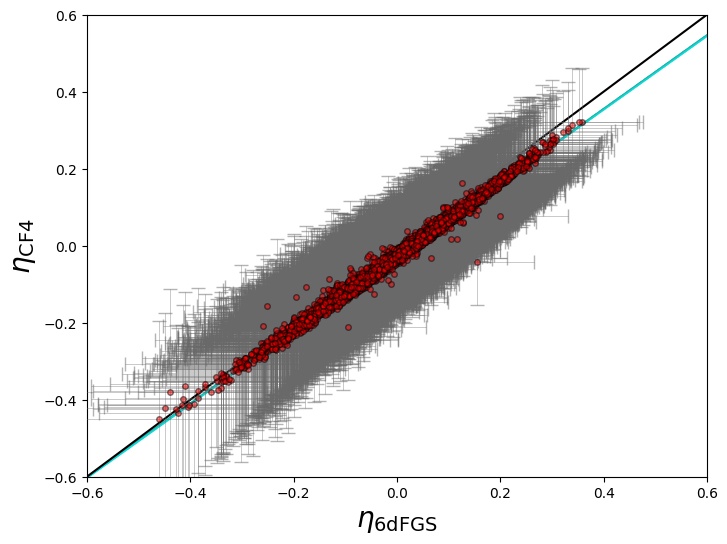

In [16]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

# My measurements
df_mine = pd.read_csv('../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/6dfgs.csv')
df_mine = df_mine[['tmass', '_6dFGS', 'logdist_all_combined', 'logdist_err_all_combined']]

# CF4 values
df_cf4 = pd.read_csv('../../data/external/logdist/CF4_6dF.csv')
df_cf4 = df_cf4[['Name', 'DzDh', 'eDz', 'Vcmb']]

df = df_mine.merge(df_cf4, left_on='_6dFGS', right_on='Name')

ndata = len(df)
x = df[f"logdist_all_combined"].to_numpy()
xerr = df[f"logdist_err_all_combined"].to_numpy()
y = df['DzDh'].to_numpy()
yerr = df['eDz'].to_numpy()

# ODR stuff
linear = Model(f)
mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
myoutput = myodr.run()
# myoutput.pprint()
m_pred, b_pred = myoutput.beta

# Create MC sample
n_trial = 10000
m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

left_lim = -0.6
right_lim = 0.6
x_trial = np.linspace(left_lim, right_lim, 1000)
y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
y_pred = m_pred * x_trial + b_pred
y_lower = np.quantile(y_trial, q=0.16, axis=0)
y_upper = np.quantile(y_trial, q=0.84, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

# Actual data + error bars
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

# Prediction + confidence intervals
ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

# 1-to-1 line
ax.plot([left_lim, right_lim], [left_lim, right_lim], c='k')

ax.set_xlim(left_lim, right_lim)
ax.set_ylim(left_lim, right_lim)
ax.set_xlabel(r"$\eta_\mathrm{survey}$".replace("survey", '6dFGS'), fontsize=20)
ax.set_ylabel(r"$\eta_\mathrm{survey}$".replace("survey", 'CF4'), fontsize=20)

Text(0, 0.5, '$\\eta_\\mathrm{H22}$')

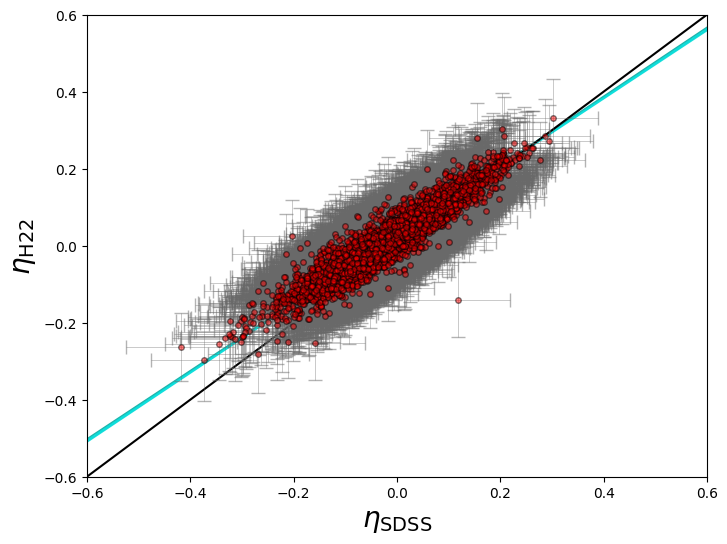

In [2]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

# My measurements
df_mine = pd.read_csv('../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv')
df_mine = df_mine[['tmass', 'objid', 'logdist_all_combined', 'logdist_err_all_combined', 'z_dist_est']]

# H22 values
df_h22 = pd.read_csv('../../data/external/logdist/cullan_logdist.csv')
df_h22['objid'] = df_h22['objid'].apply(lambda x: 'SDSS' + str(x))
df_h22 = df_h22[['objid', 'logdist_corr', 'logdist_corr_err', 'zcmb_group']]

df = df_mine.merge(df_h22, on='objid')

ndata = len(df)
x = df[f"logdist_all_combined"].to_numpy()
xerr = df[f"logdist_err_all_combined"].to_numpy()
y = df['logdist_corr'].to_numpy()
yerr = df['logdist_corr_err'].to_numpy()

# ODR stuff
linear = Model(f)
mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
myoutput = myodr.run()
# myoutput.pprint()
m_pred, b_pred = myoutput.beta

# Create MC sample
n_trial = 10000
m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

left_lim = -0.6
right_lim = 0.6
x_trial = np.linspace(left_lim, right_lim, 1000)
y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
y_pred = m_pred * x_trial + b_pred
y_lower = np.quantile(y_trial, q=0.16, axis=0)
y_upper = np.quantile(y_trial, q=0.84, axis=0)

fig, ax = plt.subplots(figsize=(8, 6))

# Actual data + error bars
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

# Prediction + confidence intervals
ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

# 1-to-1 line
ax.plot([left_lim, right_lim], [left_lim, right_lim], c='k')

ax.set_xlim(left_lim, right_lim)
ax.set_ylim(left_lim, right_lim)
ax.set_xlabel(r"$\eta_\mathrm{survey}$".replace("survey", 'SDSS'), fontsize=20)
ax.set_ylabel(r"$\eta_\mathrm{survey}$".replace("survey", 'H22'), fontsize=20)

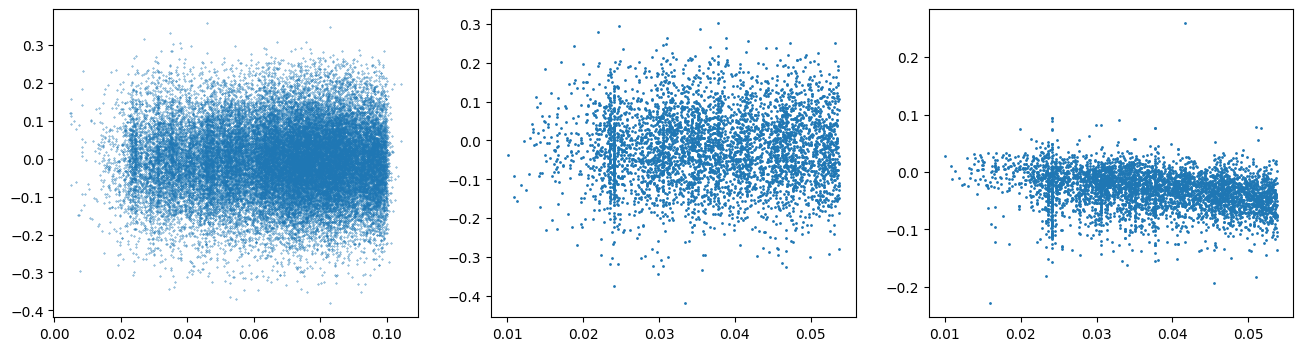

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8 * 3 / 1.5, 6 / 1.5))
df['delta_logdist'] = df['logdist_all_combined'] - df['logdist_corr']

ax1.scatter(df_h22['zcmb_group'], df_h22['logdist_corr'], s=0.1)
ax2.scatter(df_mine['z_dist_est'], df_mine['logdist_all_combined'], s=1)
ax3.scatter(df['z_dist_est'], df['delta_logdist'], s=1)

In [27]:
df_h22.columns

Index(['PGC', 'coords', 'objid', 'specObjId', 'plate', 'RA', 'Dec', 'l', 'b',
       'deVMag_g', 'deVMagErr_g', 'deVMagErr_r', 'deVMagErr_r.1', 'deVRad_r',
       'deVRadErr_r', 'deVAB_r', 'deVABErr_r', 'extinction_g', 'extinction_r',
       'kcor_r', 'kcor_g', 'absmag_r', 'zhelio', 'zhelioerr', 'zcmb',
       'SIGMA_STARS', 'SIGMA_STARS_ERR', 'IDgroupT17', 'NgroupT17',
       'zcmb_group', 'M', 'in_mask', 'nbar', 'r', 'er', 's', 'es', 'i', 'ei',
       'logdist', 'logdist_err', 'logdist_alpha', 'logdist_corr',
       'logdist_corr_err', 'logdist_corr_alpha'],
      dtype='object')

In [30]:
df

,tmass,objid,logdist_all_combined,logdist_err_all_combined,logdist_corr,logdist_corr_err
0,2MASXJ09545075+5235243,SDSS1237657771783421957,0.159442,0.090238,0.160835,0.089234
1,2MASXJ11134133+0745459,SDSS1237661972252131350,-0.032448,0.094230,-0.035157,0.097963
2,2MASXJ08100249+2251416,SDSS1237661125073502284,0.035811,0.094419,0.035379,0.090117
3,2MASXJ15330725+0445203,SDSS1237655743485640910,-0.011395,0.096363,0.068887,0.103509
4,2MASXJ12591227+3554350,SDSS1237664671641960464,-0.017591,0.091567,-0.014191,0.093872
...,...,...,...,...,...,...
4428,2MASXJ16330166+2247500,SDSS1237662665890005019,0.056179,0.091647,0.056559,0.089774
4429,2MASXJ11474317+3256514,SDSS1237665227839373443,-0.055044,0.096444,0.024214,0.103520
4430,2MASXJ13142059+1233094,SDSS1237661950260347049,-0.231180,0.100871,-0.193074,0.100121
4431,2MASXJ12030810+1109211,SDSS1237660615588970571,0.047388,0.097497,0.073280,0.095539
